In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv
/kaggle/input/gene-expression/data_set_ALL_AML_train.csv
/kaggle/input/gene-expression/actual.csv


X_train: (38, 7129)
X_test:  (34, 7129)
X_full:  (72, 7129)

Training distribution:
ALL    27
AML    11
Name: count, dtype: int64

Test distribution:
ALL    20
AML    14
Name: count, dtype: int64

ALL (27 samples):
  Mean expression range: 492.6 – 954.4
  Overall mean: 631.9, std: 2406.1

AML (11 samples):
  Mean expression range: 514.5 – 775.1
  Overall mean: 652.0, std: 2474.8

Total missing values: 0


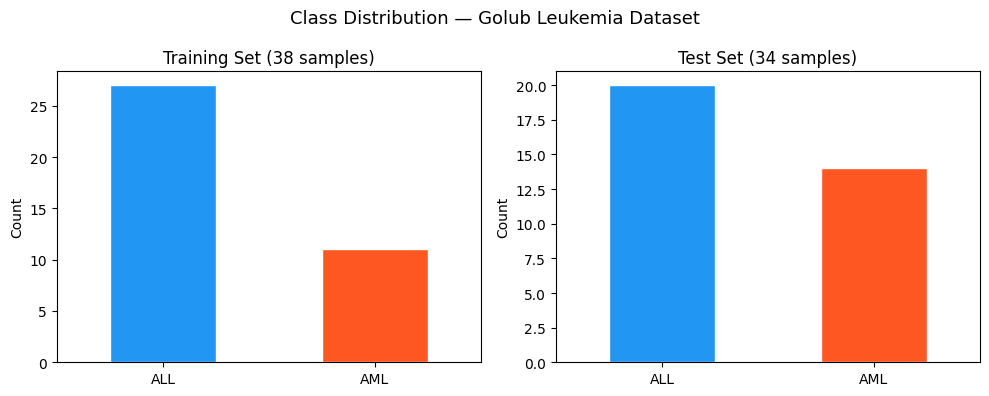

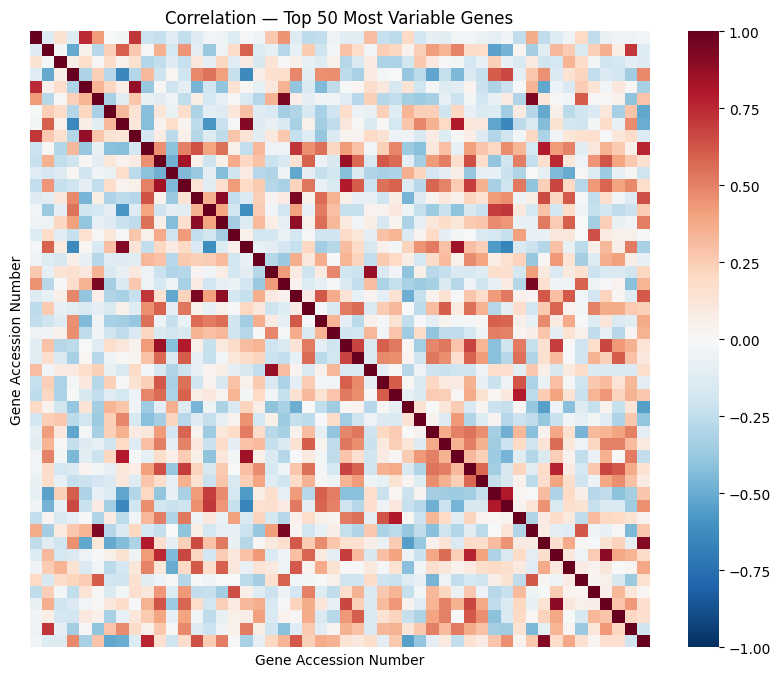

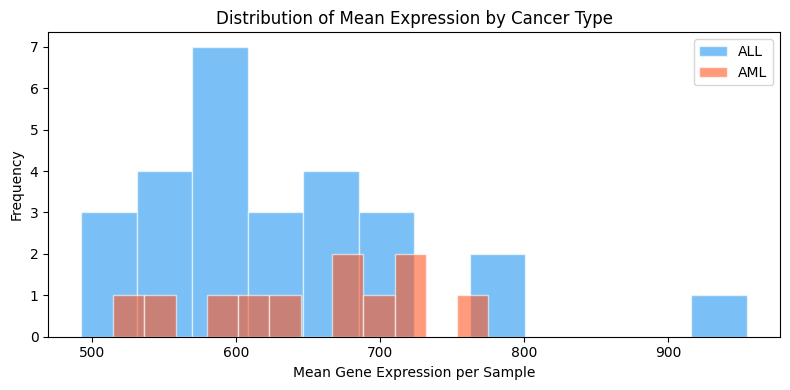

Train scaled — mean: -0.0000, std: 1.0000
Variance explained:
  PC1: 15.0%
  PC2: 12.0%
  PC3: 6.6%
  PC4: 4.9%
  PC5: 4.6%
  Cumulative (PC1-5): 43.1%


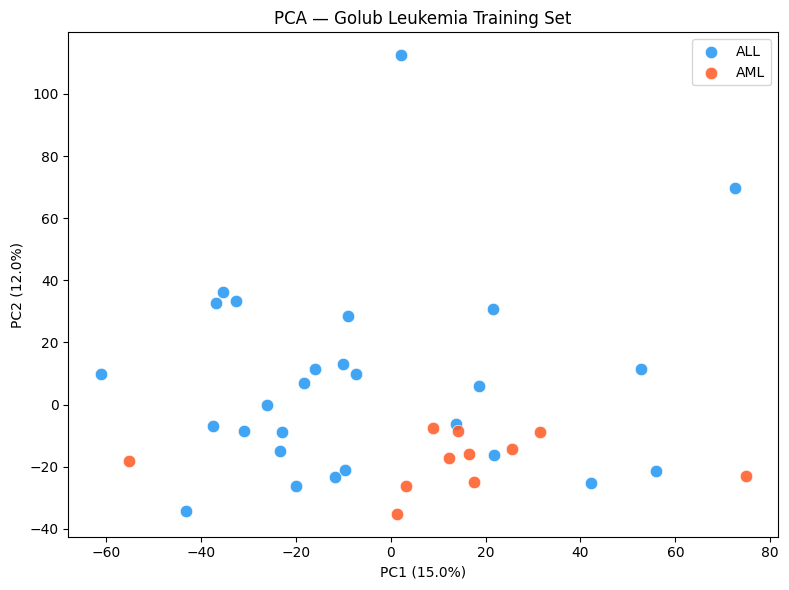

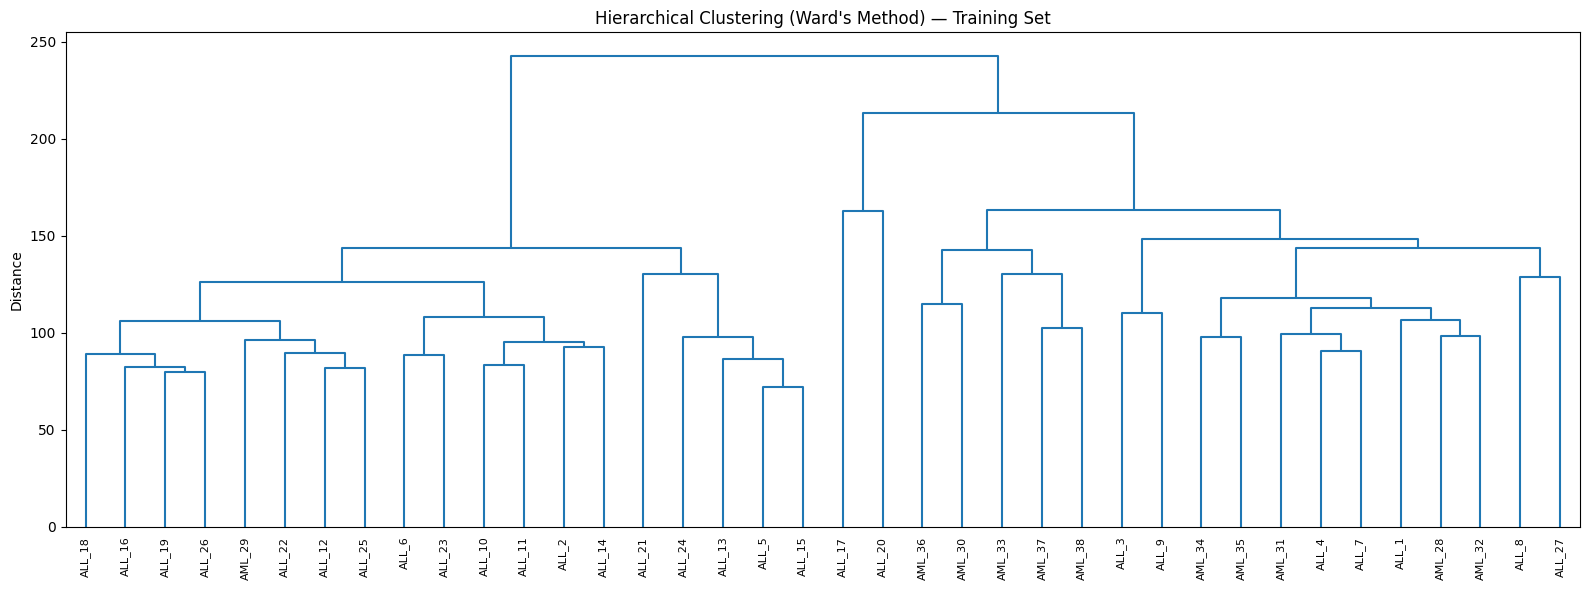

K-Means (k=2) vs True Labels:
  Adjusted Rand Index:  0.260
  Adjusted Mutual Info: 0.250

Cross-tabulation:
Cluster   0   1
True           
ALL      19   8
AML       1  10
Top 10 genes by |SNR|:
  1. M55150_at: SNR = -1.4676 (AML↑)
  2. U50136_rna1_at: SNR = -1.4217 (AML↑)
  3. X95735_at: SNR = -1.4058 (AML↑)
  4. U22376_cds2_s_at: SNR = 1.3393 (ALL↑)
  5. M16038_at: SNR = -1.2029 (AML↑)
  6. M23197_at: SNR = -1.1960 (AML↑)
  7. M84526_at: SNR = -1.1910 (AML↑)
  8. Y12670_at: SNR = -1.1847 (AML↑)
  9. U82759_at: SNR = -1.1642 (AML↑)
  10. D49950_at: SNR = -1.1398 (AML↑)

Overlap between SNR top-50 and SelectKBest top-50: 31/50 genes


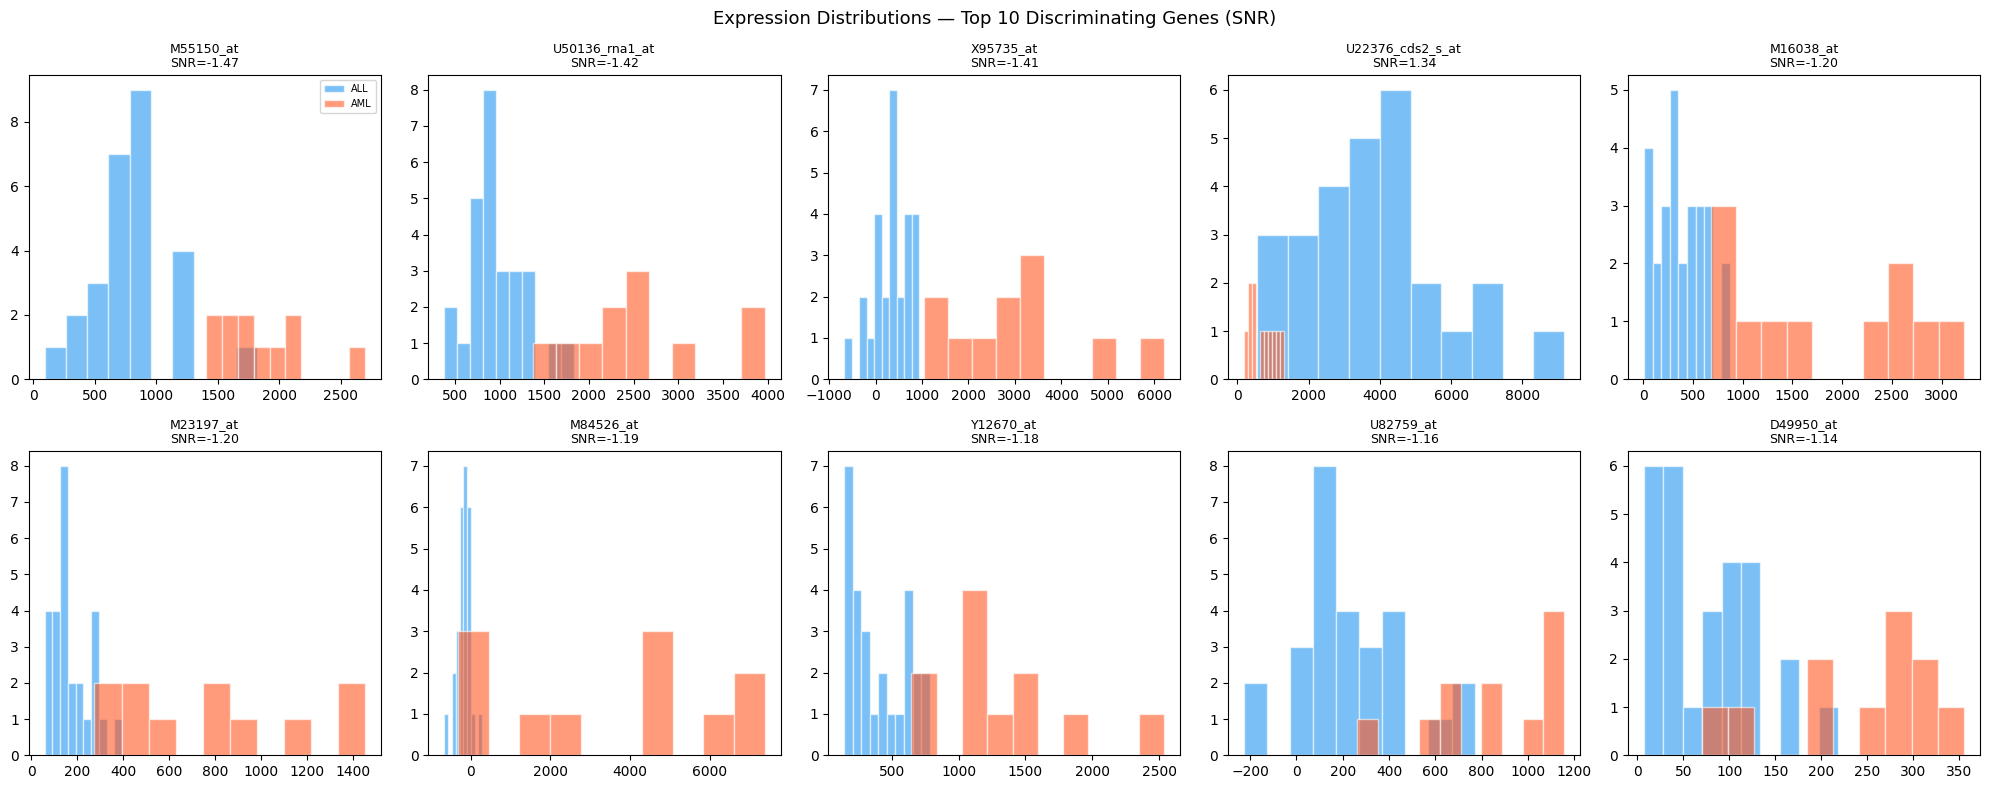

RESULTS ON GOLUB'S ORIGINAL TRAIN/TEST SPLIT

Nearest Centroid (≈Golub): 0.8235 (28/34)
              precision    recall  f1-score   support

         ALL       0.77      1.00      0.87        20
         AML       1.00      0.57      0.73        14

    accuracy                           0.82        34
   macro avg       0.88      0.79      0.80        34
weighted avg       0.86      0.82      0.81        34


Logistic Regression (L1): 0.8824 (30/34)
              precision    recall  f1-score   support

         ALL       0.90      0.90      0.90        20
         AML       0.86      0.86      0.86        14

    accuracy                           0.88        34
   macro avg       0.88      0.88      0.88        34
weighted avg       0.88      0.88      0.88        34


Logistic Regression (L2): 0.8824 (30/34)
              precision    recall  f1-score   support

         ALL       0.90      0.90      0.90        20
         AML       0.86      0.86      0.86        14

    accura

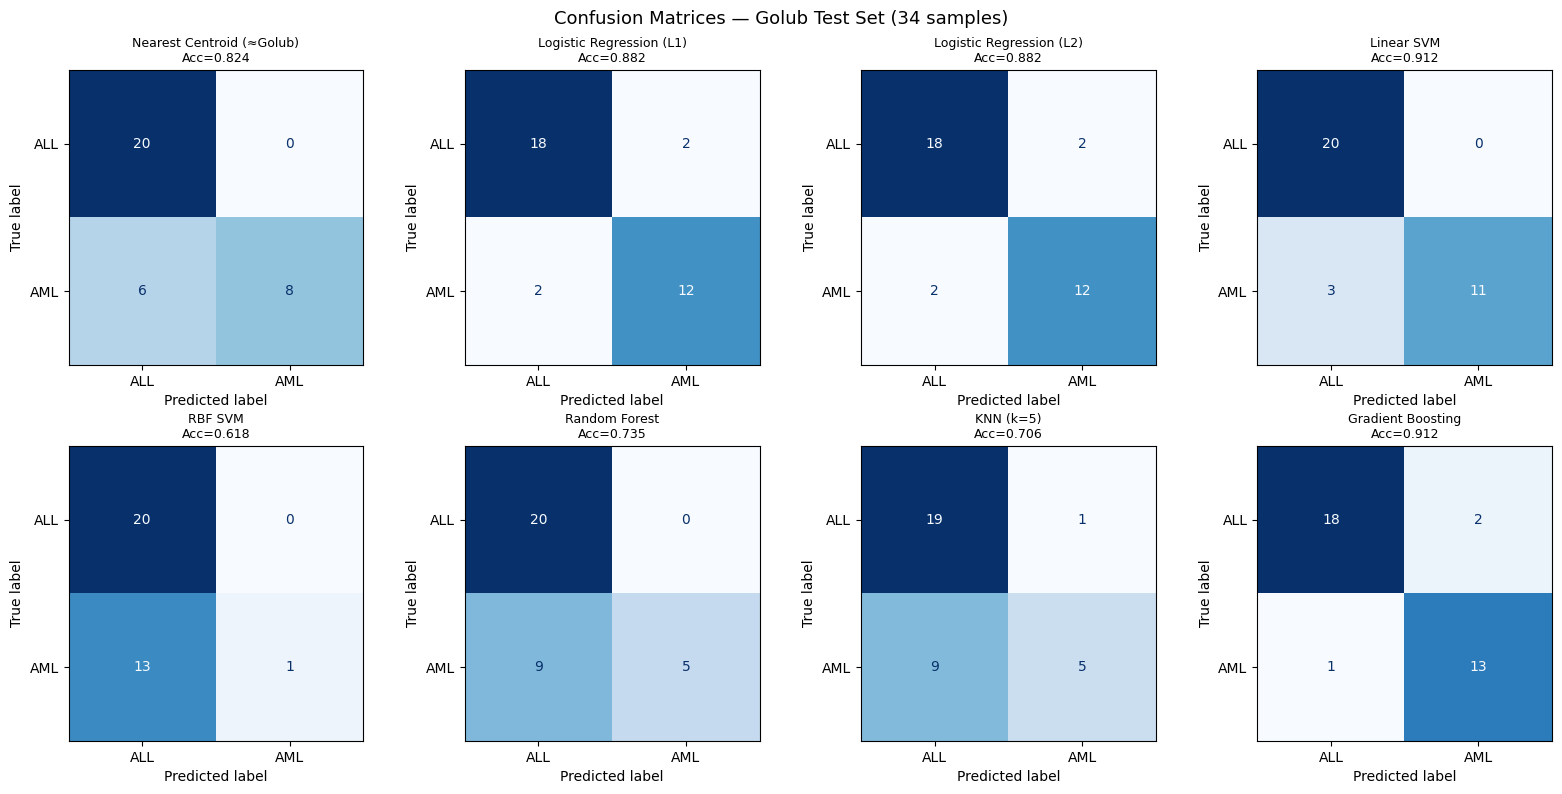


                         Classifier  Test Accuracy Test Correct   CV Mean ± Std
Golub et al. (1999) Weighted Voting       0.852941        29/34             N/A
          Nearest Centroid (≈Golub)       0.823529        28/34   0.834 ± 0.176
           Logistic Regression (L1)       0.882353        30/34   0.863 ± 0.146
           Logistic Regression (L2)       0.882353        30/34   0.905 ± 0.123
                         Linear SVM       0.911765        31/34   0.960 ± 0.080
                            RBF SVM       0.617647        21/34   0.860 ± 0.079
                      Random Forest       0.735294        25/34   0.959 ± 0.054
                          KNN (k=5)       0.705882        24/34   0.820 ± 0.090
                  Gradient Boosting       0.911765        31/34   0.846 ± 0.056
               GridSearch LR (best)       0.911765        31/34 CV-train: 0.870
              GridSearch SVM (best)       0.941176        32/34 CV-train: 0.949


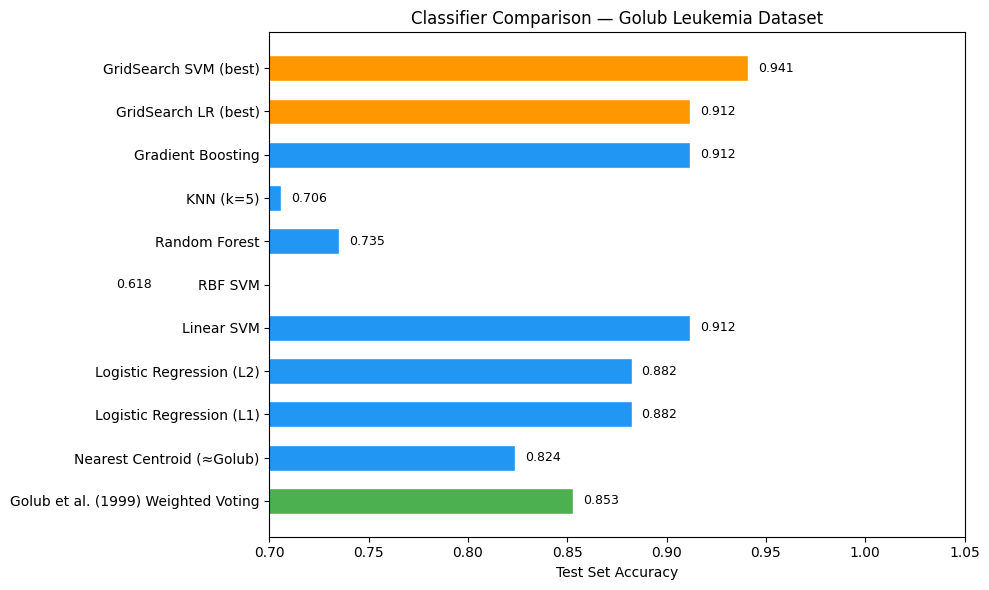


✅ Phase 1 complete. 8 figures saved.
Variables preserved: results_split, results_cv, comparison_df, top_50_snr, X_full, y_full
Grid search best params — LR: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'pca__n_components': 10}
Grid search best params — SVM: {'classifier__C': 1, 'classifier__kernel': 'rbf', 'selector__k': 25}


In [3]:
# ============================================================
# Phase 1 — Reproduce Golub's Leukemia Classification (ALL vs AML)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, adjusted_rand_score, adjusted_mutual_info_score
)
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")

# ============================================================
# STEP 1: Data Loading
# ============================================================

train_df = pd.read_csv('/kaggle/input/gene-expression/data_set_ALL_AML_train.csv')
test_df = pd.read_csv('/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv')
actual_df = pd.read_csv('/kaggle/input/gene-expression/actual.csv')

def process_data(df):
    """
    Parse Golub CSV: filter out 'call' columns, set gene accession as index,
    drop gene descriptions, transpose so patients are rows.
    """
    cols = [c for c in df.columns if "call" not in c]
    df = df[cols].set_index('Gene Accession Number').drop('Gene Description', axis=1)
    df = df.T
    df.index = df.index.astype(int)
    return df

X_train_raw = process_data(train_df)
X_test_raw = process_data(test_df)

# Map labels from actual.csv
y_train = X_train_raw.index.map(actual_df.set_index('patient')['cancer'])
y_test = X_test_raw.index.map(actual_df.set_index('patient')['cancer'])

# Full combined dataset for cross-validation later
X_full = pd.concat([X_train_raw, X_test_raw], axis=0)
y_full = pd.concat([pd.Series(y_train, index=X_train_raw.index),
                     pd.Series(y_test, index=X_test_raw.index)])

print(f"X_train: {X_train_raw.shape}")
print(f"X_test:  {X_test_raw.shape}")
print(f"X_full:  {X_full.shape}")
print(f"\nTraining distribution:\n{y_train.value_counts()}")
print(f"\nTest distribution:\n{y_test.value_counts()}")

# ============================================================
# STEP 2: Exploratory Data Analysis
# ============================================================

# --- 2a. Basic stats per class ---
for label in ["ALL", "AML"]:
    subset = X_train_raw[y_train == label]
    print(f"\n{label} ({subset.shape[0]} samples):")
    print(f"  Mean expression range: {subset.mean(axis=1).min():.1f} – {subset.mean(axis=1).max():.1f}")
    print(f"  Overall mean: {subset.values.mean():.1f}, std: {subset.values.std():.1f}")

# --- 2b. Missing values ---
print(f"\nTotal missing values: {X_full.isnull().sum().sum()}")

# --- 2c. Class distribution plot ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

y_train.value_counts().plot(kind="bar", ax=axes[0], color=["#2196F3", "#FF5722"], edgecolor="white")
axes[0].set_title("Training Set (38 samples)")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=0)

y_test.value_counts().plot(kind="bar", ax=axes[1], color=["#2196F3", "#FF5722"], edgecolor="white")
axes[1].set_title("Test Set (34 samples)")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=0)

plt.suptitle("Class Distribution — Golub Leukemia Dataset", fontsize=13)
plt.tight_layout()
plt.savefig("01_class_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

# --- 2d. Correlation heatmap of top-variance genes ---
gene_var = X_train_raw.var(axis=0)
top_50_var = gene_var.nlargest(50).index

plt.figure(figsize=(10, 8))
sns.heatmap(X_train_raw[top_50_var].corr(), cmap="RdBu_r", center=0,
            vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
plt.title("Correlation — Top 50 Most Variable Genes")
plt.savefig("02_correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

# --- 2e. Expression distribution per class ---
fig, ax = plt.subplots(figsize=(8, 4))
for label, color in [("ALL", "#2196F3"), ("AML", "#FF5722")]:
    means = X_train_raw[y_train == label].mean(axis=1)
    ax.hist(means, bins=12, alpha=0.6, color=color, label=label, edgecolor="white")
ax.set_xlabel("Mean Gene Expression per Sample")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Mean Expression by Cancer Type")
ax.legend()
plt.tight_layout()
plt.savefig("03_expression_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

# ============================================================
# STEP 3: Preprocessing (for unsupervised steps only)
# ============================================================

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_raw),
    index=X_train_raw.index, columns=X_train_raw.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_raw),
    index=X_test_raw.index, columns=X_test_raw.columns
)

print(f"Train scaled — mean: {X_train_scaled.values.mean():.4f}, std: {X_train_scaled.values.std():.4f}")

# ============================================================
# STEP 4: Unsupervised Analysis
# ============================================================

# --- 4a. PCA ---
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)

print("Variance explained:")
for i in range(5):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]*100:.1f}%")
print(f"  Cumulative (PC1-5): {pca.explained_variance_ratio_[:5].sum()*100:.1f}%")

# 2D PCA scatter
fig, ax = plt.subplots(figsize=(8, 6))
colors = {"ALL": "#2196F3", "AML": "#FF5722"}
for label in ["ALL", "AML"]:
    mask = y_train.values == label
    ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
               c=colors[label], label=label, s=80,
               edgecolors="white", linewidth=0.5, alpha=0.85)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("PCA — Golub Leukemia Training Set")
ax.legend()
plt.tight_layout()
plt.savefig("04_pca_leukemia.png", dpi=150, bbox_inches="tight")
plt.show()

# --- 4b. Hierarchical Clustering ---
linkage_matrix = linkage(X_train_scaled, method="ward", metric="euclidean")
dendro_labels = [f"{y_train[i]}_{X_train_raw.index[i]}" for i in range(len(y_train))]
plt.figure(figsize=(16, 6))
dendrogram(linkage_matrix, labels=dendro_labels,
           leaf_rotation=90, leaf_font_size=8, color_threshold=0)
plt.title("Hierarchical Clustering (Ward's Method) — Training Set")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig("05_dendrogram.png", dpi=150, bbox_inches="tight")
plt.show()

# --- 4c. K-Means + Adjusted Rand Index ---
y_train_binary = (y_train == "AML").astype(int)

kmeans = KMeans(n_clusters=2, n_init=50, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

ari = adjusted_rand_score(y_train_binary, clusters)
ami = adjusted_mutual_info_score(y_train_binary, clusters)
print(f"K-Means (k=2) vs True Labels:")
print(f"  Adjusted Rand Index:  {ari:.3f}")
print(f"  Adjusted Mutual Info: {ami:.3f}")
print(f"\nCross-tabulation:\n{pd.crosstab(y_train, clusters, rownames=['True'], colnames=['Cluster'])}")

# ============================================================
# STEP 5: Feature Selection
# ============================================================

# --- 5a. Golub's Signal-to-Noise Ratio (on raw unscaled data) ---
def signal_to_noise(X, y, pos="ALL", neg="AML"):
    """SNR = (μ_pos - μ_neg) / (σ_pos + σ_neg)"""
    X_pos, X_neg = X[y == pos], X[y == neg]
    mu_diff = X_pos.mean(axis=0) - X_neg.mean(axis=0)
    sigma_sum = X_pos.std(axis=0) + X_neg.std(axis=0)
    sigma_sum = sigma_sum.replace(0, 1e-10)
    return mu_diff / sigma_sum

snr = signal_to_noise(X_train_raw, y_train)
snr_ranked = snr.abs().sort_values(ascending=False)
top_50_snr = snr_ranked.head(50).index.tolist()
top_10_snr = snr_ranked.head(10).index.tolist()

print("Top 10 genes by |SNR|:")
for i, gene in enumerate(top_10_snr):
    direction = "ALL↑" if snr[gene] > 0 else "AML↑"
    print(f"  {i+1}. {gene}: SNR = {snr[gene]:.4f} ({direction})")

# --- 5b. Compare SNR with sklearn SelectKBest ---
selector = SelectKBest(f_classif, k=50)
selector.fit(X_train_scaled, y_train)
top_50_skb = X_train_raw.columns[selector.get_support()].tolist()

overlap = set(top_50_snr) & set(top_50_skb)
print(f"\nOverlap between SNR top-50 and SelectKBest top-50: {len(overlap)}/50 genes")

# --- 5c. Top 10 gene expression distributions ---
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, gene in enumerate(top_10_snr):
    ax = axes[i // 5][i % 5]
    for label, color in [("ALL", "#2196F3"), ("AML", "#FF5722")]:
        ax.hist(X_train_raw[y_train == label][gene], bins=10,
                alpha=0.6, color=color, label=label, edgecolor="white")
    ax.set_title(f"{gene}\nSNR={snr[gene]:.2f}", fontsize=9)
    if i == 0:
        ax.legend(fontsize=7)

plt.suptitle("Expression Distributions — Top 10 Discriminating Genes (SNR)", fontsize=13)
plt.tight_layout()
plt.savefig("06_top_genes.png", dpi=150, bbox_inches="tight")
plt.show()

# ============================================================
# STEP 6: Supervised Classification
# ============================================================

# --- 6a. Pipeline classifiers on Golub's original train/test split ---
pipeline_configs = {
    "Nearest Centroid (≈Golub)": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', NearestCentroid())
    ]),
    "Logistic Regression (L1)": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))
    ]),
    "Logistic Regression (L2)": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', LogisticRegression(solver='liblinear', penalty='l2'))
    ]),
    "Linear SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='linear', random_state=42))
    ]),
    "RBF SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='rbf', random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "KNN (k=5)": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ]),
    "Gradient Boosting": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ]),
}

print("=" * 65)
print("RESULTS ON GOLUB'S ORIGINAL TRAIN/TEST SPLIT")
print("=" * 65)

results_split = {}
for name, pipe in pipeline_configs.items():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    acc = accuracy_score(y_test, y_pred)
    results_split[name] = {
        "accuracy": acc,
        "correct": (y_pred == y_test).sum(),
        "total": len(y_test),
        "y_pred": y_pred,
    }
    print(f"\n{name}: {acc:.4f} ({(y_pred == y_test).sum()}/{len(y_test)})")
    print(classification_report(y_test, y_pred, zero_division=0))

# --- 6b. GridSearchCV with PCA Pipeline ---
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', LogisticRegression(solver='liblinear'))
])

param_grid_lr = {
    'pca__n_components': [10, 20, 30],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring='accuracy')
grid_lr.fit(X_train_raw, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_raw)

print("=" * 65)
print("GRID SEARCH — Logistic Regression Pipeline")
print("=" * 65)
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_lr)}")

# --- 6c. GridSearchCV with SVM Pipeline ---
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_classif)),
    ('classifier', SVC(random_state=42))
])

param_grid_svm = {
    'selector__k': [25, 50, 100],
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=3, scoring='accuracy')
grid_svm.fit(X_train_raw, y_train)

best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_raw)

print("=" * 65)
print("GRID SEARCH — SVM Pipeline")
print("=" * 65)
print(f"Best Parameters: {grid_svm.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_svm)}")

# --- 6d. 5-Fold CV on all 72 samples ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("=" * 65)
print("STRATIFIED 5-FOLD CV — ALL PIPELINES (full 72 samples)")
print("=" * 65)

results_cv = {}
for name, pipe in pipeline_configs.items():
    scores = cross_val_score(pipe, X_full, y_full, cv=cv, scoring='accuracy')
    results_cv[name] = {"mean": scores.mean(), "std": scores.std()}
    print(f"  {name}: {scores.mean():.3f} ± {scores.std():.3f}")

# ============================================================
# STEP 7: Evaluation
# ============================================================

# --- 7a. Confusion matrices for all classifiers ---
n_clf = len(results_split)
n_cols = 4
n_rows = (n_clf + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, (name, res) in enumerate(results_split.items()):
    cm = confusion_matrix(y_test, res["y_pred"], labels=["ALL", "AML"])
    disp = ConfusionMatrixDisplay(cm, display_labels=["ALL", "AML"])
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(f"{name}\nAcc={res['accuracy']:.3f}", fontsize=9)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Confusion Matrices — Golub Test Set (34 samples)", fontsize=13)
plt.tight_layout()
plt.savefig("07_confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()

# --- 7b. Comparison table ---
rows = []

rows.append({
    "Classifier": "Golub et al. (1999) Weighted Voting",
    "Test Accuracy": 29 / 34,
    "Test Correct": "29/34",
    "CV Mean ± Std": "N/A",
})

for name in pipeline_configs:
    rows.append({
        "Classifier": name,
        "Test Accuracy": results_split[name]["accuracy"],
        "Test Correct": f"{results_split[name]['correct']}/{results_split[name]['total']}",
        "CV Mean ± Std": f"{results_cv[name]['mean']:.3f} ± {results_cv[name]['std']:.3f}",
    })

rows.append({
    "Classifier": "GridSearch LR (best)",
    "Test Accuracy": accuracy_score(y_test, y_pred_lr),
    "Test Correct": f"{(y_pred_lr == y_test).sum()}/{len(y_test)}",
    "CV Mean ± Std": f"CV-train: {grid_lr.best_score_:.3f}",
})
rows.append({
    "Classifier": "GridSearch SVM (best)",
    "Test Accuracy": accuracy_score(y_test, y_pred_svm),
    "Test Correct": f"{(y_pred_svm == y_test).sum()}/{len(y_test)}",
    "CV Mean ± Std": f"CV-train: {grid_svm.best_score_:.3f}",
})

comparison_df = pd.DataFrame(rows)
print("\n" + "=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# --- 7c. Accuracy bar chart ---
fig, ax = plt.subplots(figsize=(10, 6))

names = comparison_df["Classifier"]
accs = comparison_df["Test Accuracy"]
colors_bar = ["#4CAF50"] + ["#2196F3"] * (len(names) - 3) + ["#FF9800", "#FF9800"]

bars = ax.barh(names, accs, color=colors_bar, edgecolor="white", height=0.6)
ax.set_xlim(0.7, 1.05)
ax.set_xlabel("Test Set Accuracy")
ax.set_title("Classifier Comparison — Golub Leukemia Dataset")

for bar, acc in zip(bars, accs):
    ax.text(acc + 0.005, bar.get_y() + bar.get_height() / 2,
            f"{acc:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.savefig("08_classifier_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

# ============================================================
# Summary
# ============================================================
print("\n✅ Phase 1 complete. 8 figures saved.")
print(f"Variables preserved: results_split, results_cv, comparison_df, top_50_snr, X_full, y_full")
print(f"Grid search best params — LR: {grid_lr.best_params_}")
print(f"Grid search best params — SVM: {grid_svm.best_params_}")